# Paris, the place to work

## Table of content
- Data collection, understanding and preparation
  - Get Paris neighborhood data and display a map of neigborhoods
  - Useful generic functions
  - Get venues by neighborhoods
  - Get companies and split by neighborhoods
  - Get building prices and split by neigborhoods
- Modeling and evaluation

Install modules

In [67]:
%pip install folium
%pip install shapely
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import primary modules

In [199]:
import numpy as np
import pandas as pd
import folium 
import os
from math import sin, cos, sqrt, atan2, radians, pi
from shapely.geometry import Point, Polygon
import requests # library to handle requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


## <u>Data collection, understanding and preparation</u>
## Get Paris neighborhood data and display a map of neigborhoods

### Get data

In [69]:
# Download Paris geojson file
#!curl -o sources/paris_neighborhoods.json "https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=geojson&timezone=Europe/Berlin&lang=fr"

In [309]:
# read json
geo_neigh = r'sources/paris_neighborhoods.json' # geojson file

### Pre-process data

In [71]:
# Get data from the file in a panda dataset
tmp = pd.read_json(geo_neigh)
tmp = pd.json_normalize(tmp.features)
FIELDS = ["properties.c_quinsee", "properties.c_qu", "properties.c_ar", "properties.geom_x_y", "properties.l_qu", "properties.surface", "properties.perimetre", "geometry.coordinates"]
paris_neigh = tmp[FIELDS]
paris_neigh.head()

,properties.c_quinsee,properties.c_qu,properties.c_ar,properties.geom_x_y,properties.l_qu,properties.surface,properties.perimetre,geometry.coordinates
0,7510301,9,3,"[48.8664702895, 2.35708313106]",Arts-et-Métiers,3.180877e+05,2482.460453,"[[[2.360209979547445, 48.86519024025307], [2.3..."
1,7510303,11,3,"[48.8591924127, 2.36320505733]",Archives,3.677284e+05,2534.100042,"[[[2.368479720528894, 48.85583081045625], [2.3..."
2,7510802,30,8,"[48.8741355756, 2.30411880972]",Faubourg-du-Roule,7.965891e+05,3773.673073,"[[[2.311968475741771, 48.86992864646887], [2.3..."
3,7510503,19,5,"[48.841684288, 2.34386092632]",Val-de-Grâce,7.036312e+05,3485.831358,"[[[2.34548425335897, 48.845073369325895], [2.3..."
4,7511502,58,15,"[48.8427112503, 2.31077745364]",Necker,1.578484e+06,5979.711469,"[[[2.306149310004038, 48.84789994583024], [2.3..."


Columns descriptions
    
|Initial name | Description | New name |
|:------------|:------------|:---------|
| c_quinsee | insee identifier of the neighborhood | n_insee |
| c_qu | sequence identifier of the neighborhood | n_neigh |
| c_ar | sequence identifier of the borrow | n_borrow |
| geom_x_y | latitude and logitude of the center of the neighborhood | center |
| l_qu | name of the neighborhood | neigh_name |
| surface | surface of the neighborhood | surface |
| perimetre | perimeter of the neighborhood | perimeter |
| coordinates | points defining polygon shape | polygon |
    

In [72]:
# Rename columns
NAMES = ["n_insee", "n_neigh", "n_borrow", "center", "neigh_name", "surface", "perimeter", "polygon"]
dict_rename = dict(zip(FIELDS, NAMES))
paris_neigh = paris_neigh.rename(columns=dict_rename)
paris_neigh.head()

,n_insee,n_neigh,n_borrow,center,neigh_name,surface,perimeter,polygon
0,7510301,9,3,"[48.8664702895, 2.35708313106]",Arts-et-Métiers,3.180877e+05,2482.460453,"[[[2.360209979547445, 48.86519024025307], [2.3..."
1,7510303,11,3,"[48.8591924127, 2.36320505733]",Archives,3.677284e+05,2534.100042,"[[[2.368479720528894, 48.85583081045625], [2.3..."
2,7510802,30,8,"[48.8741355756, 2.30411880972]",Faubourg-du-Roule,7.965891e+05,3773.673073,"[[[2.311968475741771, 48.86992864646887], [2.3..."
3,7510503,19,5,"[48.841684288, 2.34386092632]",Val-de-Grâce,7.036312e+05,3485.831358,"[[[2.34548425335897, 48.845073369325895], [2.3..."
4,7511502,58,15,"[48.8427112503, 2.31077745364]",Necker,1.578484e+06,5979.711469,"[[[2.306149310004038, 48.84789994583024], [2.3..."


In [73]:
# get infos on dataframe
print(paris_neigh.shape)
print(paris_neigh.info())

(80, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   n_insee     80 non-null     int64  
 1   n_neigh     80 non-null     int64  
 2   n_borrow    80 non-null     int64  
 3   center      80 non-null     object 
 4   neigh_name  80 non-null     object 
 5   surface     80 non-null     float64
 6   perimeter   80 non-null     float64
 7   polygon     80 non-null     object 
dtypes: float64(2), int64(3), object(3)
memory usage: 5.1+ KB
None


In [74]:
# convert last column to polygon object
paris_neigh['polygon'] = paris_neigh['polygon'].apply(lambda x: Polygon(x[0]))
paris_neigh.head()

,n_insee,n_neigh,n_borrow,center,neigh_name,surface,perimeter,polygon
0,7510301,9,3,"[48.8664702895, 2.35708313106]",Arts-et-Métiers,3.180877e+05,2482.460453,"POLYGON ((2.360209979547445 48.86519024025307,..."
1,7510303,11,3,"[48.8591924127, 2.36320505733]",Archives,3.677284e+05,2534.100042,"POLYGON ((2.368479720528894 48.85583081045625,..."
2,7510802,30,8,"[48.8741355756, 2.30411880972]",Faubourg-du-Roule,7.965891e+05,3773.673073,"POLYGON ((2.311968475741771 48.86992864646887,..."
3,7510503,19,5,"[48.841684288, 2.34386092632]",Val-de-Grâce,7.036312e+05,3485.831358,"POLYGON ((2.34548425335897 48.8450733693259, 2..."
4,7511502,58,15,"[48.8427112503, 2.31077745364]",Necker,1.578484e+06,5979.711469,"POLYGON ((2.306149310004038 48.84789994583024,..."


In [75]:
# function to get the radius of the circle containing the borrow (used as a parameter for foursquare API)
def get_radius(p):
    # approximate radius of earth in m
    R = 6373.0 * 1000
    b = p.bounds 
    lat1 = radians(b[0])
    lon1 = radians(b[1])
    lat2 = radians(b[2])
    lon2 = radians(b[3])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c / 2

paris_neigh['radius'] = paris_neigh['polygon'].apply(get_radius)
paris_neigh


,n_insee,n_neigh,n_borrow,center,neigh_name,surface,perimeter,polygon,radius
0,7510301,9,3,"[48.8664702895, 2.35708313106]",Arts-et-Métiers,3.180877e+05,2482.460453,"POLYGON ((2.360209979547445 48.86519024025307,...",760.598538
1,7510303,11,3,"[48.8591924127, 2.36320505733]",Archives,3.677284e+05,2534.100042,"POLYGON ((2.368479720528894 48.85583081045625,...",749.980901
2,7510802,30,8,"[48.8741355756, 2.30411880972]",Faubourg-du-Roule,7.965891e+05,3773.673073,"POLYGON ((2.311968475741771 48.86992864646887,...",1142.953703
3,7510503,19,5,"[48.841684288, 2.34386092632]",Val-de-Grâce,7.036312e+05,3485.831358,"POLYGON ((2.34548425335897 48.8450733693259, 2...",930.525821
4,7511502,58,15,"[48.8427112503, 2.31077745364]",Necker,1.578484e+06,5979.711469,"POLYGON ((2.306149310004038 48.84789994583024,...",1804.319907
...,...,...,...,...,...,...,...,...,...
75,7510601,21,6,"[48.8543844036, 2.34003537113]",Monnaie,2.933606e+05,2391.122818,"POLYGON ((2.343168550439539 48.85138855000365,...",658.080180
76,7510602,22,6,"[48.847800629299996, 2.33633882759]",Odéon,7.161484e+05,3516.314464,"POLYGON ((2.33698866720655 48.85290195941386, ...",929.355340
77,7510801,29,8,"[48.8670744922, 2.30865168468]",Champs-Elysées,1.140254e+06,5480.652870,"POLYGON ((2.306463844245763 48.87014801524102,...",1682.212594
78,7511303,51,13,"[48.8231278057, 2.35243314954]",Maison-Blanche,2.231506e+06,6814.373288,"POLYGON ((2.349115013991671 48.82959683468229,...",1694.808353


In [76]:
# add borrow insee code
paris_neigh['n_insee_borrow'] = (paris_neigh['n_insee']/100).astype(int)
paris_neigh.sort_values(by='n_neigh', axis=0, inplace=True)
paris_neigh

,n_insee,n_neigh,n_borrow,center,neigh_name,surface,perimeter,polygon,radius,n_insee_borrow
67,7510101,1,1,"[48.8606501352, 2.33491032928]",Saint-Germain-l'Auxerrois,8.690007e+05,5057.549475,"POLYGON ((2.344593389828428 48.85404991486193,...",1669.278867,75101
41,7510102,2,1,"[48.8622891081, 2.34489885831]",Halles,4.124585e+05,2606.417128,"POLYGON ((2.349365804803003 48.86057567227664,...",770.778719,75101
14,7510103,3,1,"[48.8646599781, 2.33630891897]",Palais-Royal,2.736968e+05,2166.839239,"POLYGON ((2.339465868602756 48.86213531210705,...",641.194718,75101
49,7510104,4,1,"[48.8670185906, 2.3285816649299997]",Place-Vendôme,2.694568e+05,2147.817602,"POLYGON ((2.331944969393233 48.86491285292421,...",653.448293,75101
72,7510201,5,2,"[48.8693066381, 2.33343180766]",Gaillon,1.880122e+05,1866.982041,"POLYGON ((2.336320212305948 48.8679713890312, ...",558.648294,75102
...,...,...,...,...,...,...,...,...,...,...
50,7511904,76,19,"[48.8786390757, 2.38012728183]",Combat,1.294988e+06,4435.273252,"POLYGON ((2.388343313526396 48.88056667377271,...",1316.063333,75119
32,7512001,77,20,"[48.8715312006, 2.38754923985]",Belleville,8.065686e+05,3738.454432,"POLYGON ((2.383226691675032 48.86709755024515,...",1163.376686,75120
36,7512002,78,20,"[48.8710347391, 2.40617153015]",Saint-Fargeau,1.486971e+06,5405.036433,"POLYGON ((2.413813296947322 48.87081017440517,...",1370.244796,75120
5,7512003,79,20,"[48.863719484, 2.39527282076]",Père-Lachaise,1.599002e+06,5013.656432,"POLYGON ((2.395358818714641 48.85669837121318,...",1512.558290,75120


### Vizualize data

In [77]:
# add chopleth based on the surface for now
# Display a map centered on Paris
paris_lat = 48.8534100
paris_long = 2.3488000
    
# create a plain world map

paris_map = folium.Map(location=[paris_lat, paris_long], zoom_start=12, min_zoom=12)

folium.Choropleth(
    geo_data=geo_neigh,
    data=paris_neigh,
    columns=['n_insee', 'surface'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Paris Neighborhoods'
).add_to(paris_map)
paris_map

## Useful generic functions

### Function to know in what neighborhood is a place
Based on coordinates, tells in which neigborhood is the place. Return None if not in a known neighborhood

In [78]:
def get_neighborhood(lat, long, neigh):
    p = Point(long, lat) # In GeoJSON coordinates are in this order, so we need to keep it that way
    for i,v in neigh.iterrows():
        if p.within(v['polygon']):
            return v['n_insee']
    return None

In [79]:
def get_neighborhoods(latSerie, longSerie, neigh, borrowSerie = None):
    a = []
    if borrowSerie is not None:
        for lat,long, borrow in zip(latSerie,longSerie, borrowSerie):
            n = neigh[neigh['n_insee_borrow'] == int(borrow)]
            a.append(get_neighborhood(lat, long, n))
    else:
        for lat,long in zip(latSerie,longSerie):
            a.append(get_neighborhood(lat, long, neigh))

    return a

In [80]:
# Test function with 2 locations
# with paris center
c = get_neighborhood(paris_lat, paris_long, paris_neigh)
print('The center of Paris is in neigborhood',c if c is not None else 'error')
c = get_neighborhood(0, 0, paris_neigh)
print('Point 0,0 in neigborhood',c)


The center of Paris is in neigborhood 7510404
Point 0,0 in neigborhood None


## Get venues by neighborhoods

### Get data

In [82]:
CLIENT_ID = os.environ['FOURSQUARE_ID'] # your Foursquare ID
CLIENT_SECRET = os.environ['FOURSQUARE_SECRET'] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 10000

In [83]:
venues_list=[]
for c, r, n in zip(paris_neigh['center'], paris_neigh['radius'], paris_neigh['n_insee']):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        c[0], 
        c[1], 
        r, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()["response"]['venues']# ['groups'][0]['items']
    print(n, len(results))

    # return only relevant information for each nearby venue
    venues_list.append([(
        v['name'], #['venue'] 
        v['location']['lat'], 
        v['location']['lng'],  
        v['categories'][0]['name'] if len(v['categories'])>0 else None) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = [
              'venue', 
              'venue_lat', 
              'venue_long', 
              'venue_category']
nearby_venues.drop_duplicates(inplace=True)

7510101 124
7510102 122
7510103 125
7510104 126
7510201 124
7510202 121
7510203 126
7510204 126
7510301 122
7510302 122
7510303 114
7510304 120
7510401 120
7510402 123
7510403 40
7510404 116
7510501 96
7510502 116
7510503 117
7510504 124
7510601 120
7510602 96
7510603 105
7510604 125
7510701 126
7510702 121
7510703 120
7510704 121
7510801 110
7510802 112
7510803 126
7510804 120
7510901 115
7510902 127
7510903 124
7510904 118
7511001 81
7511002 124
7511003 121
7511004 100
7511101 123
7511102 121
7511103 122
7511104 104
7511201 116
7511202 116
7511203 109
7511204 119
7511301 103
7511302 119
7511303 94
7511304 77
7511401 61
7511402 93
7511403 121
7511404 120
7511501 76
7511502 120
7511503 121
7511504 121
7511601 124
7511602 116
7511603 106
7511604 120
7511701 122
7511702 96
7511703 103
7511704 76
7511801 124
7511802 122
7511803 122
7511804 70
7511901 125
7511902 117
7511903 103
7511904 120
7512001 58
7512002 112
7512003 124
7512004 119


In [84]:
nearby_venues

,venue,venue_lat,venue_long,venue_category
0,Musée du Louvre,48.860847,2.336440,Art Museum
1,Café Mollien,48.860707,2.334696,Café
2,Pyramide du Louvre,48.861023,2.335850,Monument / Landmark
3,모나리자 / 라 조콘다 (Mona Lisa | La Joconde),48.860139,2.335337,Exhibit
4,Café de l'Ours,48.859850,2.327440,Café
...,...,...,...,...
8966,Greenpeace France,48.854451,2.409329,Office
8967,3 Horloges,48.853214,2.409477,Middle Eastern Restaurant
8968,Voyagiste,48.853324,2.409426,General Travel
8969,Laboratoire des Analyses Medicales Blaise Pascal,48.854090,2.410220,Medical Lab


### Pre-process data

In [85]:
# get Neighborhoods
nearby_venues['neighborhood'] = get_neighborhoods(nearby_venues['venue_lat'], nearby_venues['venue_long'], paris_neigh)
nearby_venues

,venue,venue_lat,venue_long,venue_category,neighborhood
0,Musée du Louvre,48.860847,2.336440,Art Museum,7510101.0
1,Café Mollien,48.860707,2.334696,Café,7510101.0
2,Pyramide du Louvre,48.861023,2.335850,Monument / Landmark,7510101.0
3,모나리자 / 라 조콘다 (Mona Lisa | La Joconde),48.860139,2.335337,Exhibit,7510101.0
4,Café de l'Ours,48.859850,2.327440,Café,7510701.0
...,...,...,...,...,...
8966,Greenpeace France,48.854451,2.409329,Office,7512004.0
8967,3 Horloges,48.853214,2.409477,Middle Eastern Restaurant,7512004.0
8968,Voyagiste,48.853324,2.409426,General Travel,7512004.0
8969,Laboratoire des Analyses Medicales Blaise Pascal,48.854090,2.410220,Medical Lab,7512004.0


### Explore data

In [86]:
nearby_venues['venue_category'].value_counts()

Office                                      622
French Restaurant                           298
Hotel                                       204
Residential Building (Apartment / Condo)    191
Art Gallery                                 185
                                           ... 
North Indian Restaurant                       1
Drugstore                                     1
Town Hall                                     1
Sauna / Steam Room                            1
Herbs & Spices Store                          1
Name: venue_category, Length: 485, dtype: int64

## Get companies and split by neighborhoods

### Get data

In [87]:
# Download companies files - we take a version of the file containing latitude and longitude
borrows = range(75101,75121,1)
for b in borrows:
    name = "geo_siret_"+str(b)+".csv.gz"
    url = "http://data.cquest.org/geo_sirene/v2019/last/dep/"+name
    #!curl -o sources/$name $url

In [88]:
# Download NAF classification of companies activities
#!curl -o sources/naf.xls https://www.insee.fr/fr/statistiques/fichier/2120875/naf2008_liste_n2.xls

### Pre-process data

In [89]:
# Read files into dataframe and keep only used columns
borrows = range(75101,75121,1)

companies = pd.DataFrame()

for b in borrows:
    name = "sources/geo_siret_"+str(b)+".csv.gz"
    df = pd.read_csv(name, usecols=['etatAdministratifEtablissement', 'longitude', 'latitude', 'activitePrincipaleEtablissement'])
    df['borrow'] = str(b)
    companies = companies.append(df[df['etatAdministratifEtablissement'] == 'A']) # only keep active companies


In [90]:
# clean dataframe
# remove already used column
companies.drop(columns=['etatAdministratifEtablissement'], inplace=True)
# split activity code (we'll keep only the highest level first 2 chars)
companies['naf_code'] = companies['activitePrincipaleEtablissement'].str[:2]
companies.rename(columns={'activitePrincipaleEtablissement':'naf_detailed_code'}, inplace=True)
companies['naf_code'] = companies['naf_code'].astype(int)
companies['longitude'] = companies['longitude'].astype(float)
companies['latitude'] = companies['latitude'].astype(float)
companies.head()

,naf_detailed_code,longitude,latitude,borrow,naf_code
9,46.21Z,2.341768,48.863217,75101,46
10,81.10Z,2.346192,48.858301,75101,81
11,81.10Z,2.346540,48.863854,75101,81
12,81.10Z,2.331435,48.865260,75101,81
13,81.10Z,2.341220,48.862005,75101,81


In [91]:
# Read NAF file and add activity to companies list
naf = pd.read_excel('sources/naf.xls', header=2, index_col=0)
naf

,Libellé
Code,
1,"Culture et production animale, chasse et servi..."
2,Sylviculture et exploitation forestière
3,Pêche et aquaculture
5,Extraction de houille et de lignite
6,Extraction d'hydrocarbures
...,...
95,Réparation d'ordinateurs et de biens personnel...
96,Autres services personnels
97,Activités des ménages en tant qu'employeurs de...


In [92]:
# add work domain of the company
companies = companies.join(naf, 'naf_code')
# rename column libellé to naf_label
companies = companies.rename(columns={'Libellé': 'naf_label'})
companies

,naf_detailed_code,longitude,latitude,borrow,naf_code,naf_label
9,46.21Z,2.341768,48.863217,75101,46,"Commerce de gros, à l'exception des automobile..."
10,81.10Z,2.346192,48.858301,75101,81,Services relatifs aux bâtiments et aménagement...
11,81.10Z,2.346540,48.863854,75101,81,Services relatifs aux bâtiments et aménagement...
12,81.10Z,2.331435,48.865260,75101,81,Services relatifs aux bâtiments et aménagement...
13,81.10Z,2.341220,48.862005,75101,81,Services relatifs aux bâtiments et aménagement...
...,...,...,...,...,...,...
133278,69.20Z,2.402994,48.850066,75120,69,Activités juridiques et comptables
133283,46.74A,2.406067,48.850525,75120,46,"Commerce de gros, à l'exception des automobile..."
133284,46.63Z,2.390831,48.858338,75120,46,"Commerce de gros, à l'exception des automobile..."
133285,46.63Z,2.410937,48.847763,75120,46,"Commerce de gros, à l'exception des automobile..."


In [93]:
companies['naf_label'].value_counts()

Activités immobilières                                                 189285
Activités des sièges sociaux ; conseil de gestion                       81681
Commerce de détail, à l'exception des automobiles et des motocycles     57422
Activités créatives, artistiques et de spectacle                        51714
Services relatifs aux bâtiments et aménagement paysager                 46732
                                                                        ...  
Services de soutien aux industries extractives                             13
Extraction de minerais métalliques                                         11
Fabrication de produits à base de tabac                                     7
Cokéfaction et raffinage                                                    5
Extraction de houille et de lignite                                         1
Name: naf_label, Length: 86, dtype: int64

In [94]:
# Remove the SCI from the dataset (SCI are private companies to own propeties, it is widely used for rental or for owning a propety among a family)
print('before: ', companies.shape)
companies = companies[~companies['naf_detailed_code'].str.startswith('68.20')]
print('after: ', companies.shape)
companies['naf_label'].value_counts()

before:  (949276, 6)
after:  (786687, 6)


Activités des sièges sociaux ; conseil de gestion                      81681
Commerce de détail, à l'exception des automobiles et des motocycles    57422
Activités créatives, artistiques et de spectacle                       51714
Services relatifs aux bâtiments et aménagement paysager                46732
Activités des organisations associatives                               44765
                                                                       ...  
Services de soutien aux industries extractives                            13
Extraction de minerais métalliques                                        11
Fabrication de produits à base de tabac                                    7
Cokéfaction et raffinage                                                   5
Extraction de houille et de lignite                                        1
Name: naf_label, Length: 86, dtype: int64

In [95]:
# add neighborhood code
companies['neighborhood'] = get_neighborhoods(companies['latitude'], companies['longitude'], paris_neigh, companies['borrow'])
companies

<ipython-input-95-600261561cff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['neighborhood'] = get_neighborhoods(companies['latitude'], companies['longitude'], paris_neigh, companies['borrow'])


,naf_detailed_code,longitude,latitude,borrow,naf_code,naf_label,neighborhood
9,46.21Z,2.341768,48.863217,75101,46,"Commerce de gros, à l'exception des automobile...",7510102.0
10,81.10Z,2.346192,48.858301,75101,81,Services relatifs aux bâtiments et aménagement...,7510101.0
11,81.10Z,2.346540,48.863854,75101,81,Services relatifs aux bâtiments et aménagement...,7510102.0
12,81.10Z,2.331435,48.865260,75101,81,Services relatifs aux bâtiments et aménagement...,7510104.0
13,81.10Z,2.341220,48.862005,75101,81,Services relatifs aux bâtiments et aménagement...,7510102.0
...,...,...,...,...,...,...,...
133278,69.20Z,2.402994,48.850066,75120,69,Activités juridiques et comptables,7512004.0
133283,46.74A,2.406067,48.850525,75120,46,"Commerce de gros, à l'exception des automobile...",7512004.0
133284,46.63Z,2.390831,48.858338,75120,46,"Commerce de gros, à l'exception des automobile...",7512003.0
133285,46.63Z,2.410937,48.847763,75120,46,"Commerce de gros, à l'exception des automobile...",7512004.0


### Vizualize data

In [96]:
# display the most common activities by neigborhood
companies.pivot_table(values= 'latitude',index='naf_label', columns='neighborhood', aggfunc=len)

neighborhood,7510101.0,7510102.0,7510103.0,7510104.0,7510201.0,7510202.0,7510203.0,7510204.0,7510301.0,7510302.0,...,7511803.0,7511804.0,7511901.0,7511902.0,7511903.0,7511904.0,7512001.0,7512002.0,7512003.0,7512004.0
naf_label,,,,,,,,,,,,,,,,,,,,,
Action sociale sans hébergement,21.0,45.0,23.0,14.0,8.0,16.0,22.0,27.0,36.0,21.0,...,70.0,64.0,146.0,95.0,163.0,85.0,155.0,80.0,122.0,152.0
Activités administratives et autres activités de soutien aux entreprises,31.0,186.0,108.0,150.0,79.0,145.0,130.0,140.0,114.0,83.0,...,80.0,90.0,186.0,99.0,257.0,170.0,181.0,125.0,193.0,209.0
Activités auxiliaires de services financiers et d'assurance,27.0,188.0,150.0,281.0,202.0,205.0,133.0,124.0,93.0,59.0,...,29.0,23.0,79.0,48.0,86.0,86.0,61.0,52.0,105.0,93.0
"Activités créatives, artistiques et de spectacle",77.0,391.0,133.0,141.0,61.0,126.0,260.0,432.0,411.0,459.0,...,800.0,483.0,1092.0,474.0,1181.0,1238.0,1277.0,941.0,1577.0,1206.0
Activités d'architecture et d'ingénierie ; activités de contrôle et analyses techniques,22.0,155.0,64.0,115.0,79.0,80.0,134.0,141.0,122.0,116.0,...,128.0,94.0,228.0,115.0,271.0,271.0,326.0,183.0,302.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Transports terrestres et transport par conduites,10.0,104.0,18.0,54.0,9.0,32.0,18.0,34.0,68.0,20.0,...,230.0,229.0,413.0,326.0,541.0,202.0,406.0,269.0,330.0,443.0
"Travail du bois et fabrication d'articles en bois et en liège, à l'exception des meubles ; fabrication d'articles en vannerie et sparterie",NaN,1.0,NaN,1.0,NaN,1.0,1.0,2.0,2.0,2.0,...,7.0,4.0,2.0,1.0,3.0,4.0,2.0,2.0,5.0,4.0
Travaux de construction spécialisés,24.0,162.0,44.0,114.0,44.0,144.0,71.0,208.0,206.0,58.0,...,283.0,324.0,485.0,437.0,626.0,379.0,1459.0,285.0,1156.0,916.0


## Get building prices and split by neigborhoods

In [97]:
#!curl -o buildings.csv.gz https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/2019/departements/75.csv.gz

In [98]:
FIELDS_BUILDINGS = ['valeur_fonciere', 'code_commune', 'surface_reelle_bati', 'longitude', 'latitude', 'nombre_lots', 'code_type_local', 'nature_mutation']
buildings = pd.read_csv('sources/buildings.csv.gz', usecols=FIELDS_BUILDINGS)
buildings.dropna(inplace=True)
buildings

,nature_mutation,valeur_fonciere,code_commune,nombre_lots,code_type_local,surface_reelle_bati,longitude,latitude
0,Vente,1196000.0,75101,2,2.0,112.0,2.325288,48.868416
1,Vente,1570490.0,75103,2,2.0,104.0,2.363076,48.860305
4,Vente,5400.0,75103,1,2.0,21.0,2.353479,48.864674
5,Vente,230000.0,75103,1,2.0,26.0,2.354961,48.868615
7,Vente,955750.0,75108,2,2.0,80.0,2.314393,48.880118
...,...,...,...,...,...,...,...,...
57768,Vente,17521000.0,75104,0,2.0,66.0,2.356735,48.851162
57769,Vente,17521000.0,75104,0,2.0,120.0,2.356735,48.851162
57771,Adjudication,610000.0,75104,2,2.0,44.0,2.363869,48.852870
57772,Vente,1400000.0,75102,3,4.0,100.0,2.348095,48.866431


Columns descriptions
    
|Initial name | Description | New name |
|:------------|:------------|:---------|
| valeur_fonciere | sell price | price |
| code_commune | insee identifier of the borrow | borrow |
| surface_reelle_bati | sequence identifier of the borrow | surface |
| longitude | longitude of the building | longitude |
| latitude | latitude of the building | latitude |
| nombre_lots | number of lots in transaction | nb_lots |
| code_type_local | type of property (house, appartment, building...) | property_type |
| nature_mutation | type of transaction (sold, given, exchanged...) | transaction_type |

    

In [99]:
NAMES_BUILDINGS = ["price", "borrow", "surface", "longitude", "latitude", "nb_lots", "property_type", "transaction_type"]
dict_rename_buildings = dict(zip(FIELDS_BUILDINGS, NAMES_BUILDINGS))
buildings = buildings.rename(columns=dict_rename_buildings)
buildings.head()

,transaction_type,price,borrow,nb_lots,property_type,surface,longitude,latitude
0,Vente,1196000.0,75101,2,2.0,112.0,2.325288,48.868416
1,Vente,1570490.0,75103,2,2.0,104.0,2.363076,48.860305
4,Vente,5400.0,75103,1,2.0,21.0,2.353479,48.864674
5,Vente,230000.0,75103,1,2.0,26.0,2.354961,48.868615
7,Vente,955750.0,75108,2,2.0,80.0,2.314393,48.880118


In [100]:
buildings['price_index'] = buildings['price']/buildings['surface']
buildings

,transaction_type,price,borrow,nb_lots,property_type,surface,longitude,latitude,price_index
0,Vente,1196000.0,75101,2,2.0,112.0,2.325288,48.868416,10678.571429
1,Vente,1570490.0,75103,2,2.0,104.0,2.363076,48.860305,15100.865385
4,Vente,5400.0,75103,1,2.0,21.0,2.353479,48.864674,257.142857
5,Vente,230000.0,75103,1,2.0,26.0,2.354961,48.868615,8846.153846
7,Vente,955750.0,75108,2,2.0,80.0,2.314393,48.880118,11946.875000
...,...,...,...,...,...,...,...,...,...
57768,Vente,17521000.0,75104,0,2.0,66.0,2.356735,48.851162,265469.696970
57769,Vente,17521000.0,75104,0,2.0,120.0,2.356735,48.851162,146008.333333
57771,Adjudication,610000.0,75104,2,2.0,44.0,2.363869,48.852870,13863.636364
57772,Vente,1400000.0,75102,3,4.0,100.0,2.348095,48.866431,14000.000000


In [101]:
# remove unwanted transaction and clean columns
buildings = buildings[buildings['transaction_type'].eq('Vente') & buildings['nb_lots'].gt(0) & buildings['property_type'].eq(2)]
buildings.drop(['transaction_type', 'nb_lots', 'property_type'], axis=1)

,price,borrow,surface,longitude,latitude,price_index
0,1196000.0,75101,112.0,2.325288,48.868416,10678.571429
1,1570490.0,75103,104.0,2.363076,48.860305,15100.865385
4,5400.0,75103,21.0,2.353479,48.864674,257.142857
5,230000.0,75103,26.0,2.354961,48.868615,8846.153846
7,955750.0,75108,80.0,2.314393,48.880118,11946.875000
...,...,...,...,...,...,...
57716,480000.0,75102,42.0,2.350482,48.865949,11428.571429
57719,696500.0,75104,50.0,2.362102,48.854584,13930.000000
57720,852400.0,75104,67.0,2.358859,48.854241,12722.388060
57748,680000.0,75102,72.0,2.337572,48.867594,9444.444444


### Vizualize data

<AxesSubplot:xlabel='surface', ylabel='price'>

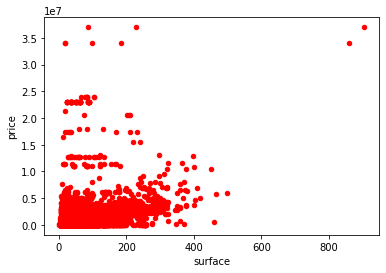

In [102]:
buildings.plot.scatter('surface', 'price', c = 'red')

<AxesSubplot:ylabel='Density'>

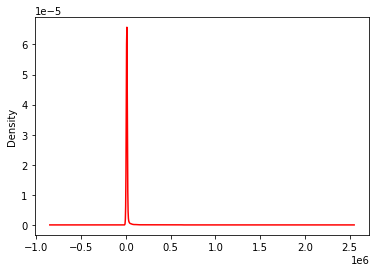

In [103]:
buildings['price_index'].plot.kde(c = 'red')

In [104]:
buildings.describe()

,price,borrow,nb_lots,property_type,surface,longitude,latitude,price_index
count,3.262000e+04,32620.000000,32620.000000,32620.0,32620.000000,32620.000000,32620.000000,3.262000e+04
mean,7.004827e+05,75113.581698,1.678265,2.0,53.449816,2.337008,48.864829,1.465682e+04
std,1.449741e+06,5.053026,0.833413,0.0,40.965389,0.037168,0.019944,3.754786e+04
min,1.000000e+00,75101.000000,1.000000,2.0,2.000000,2.255896,48.819493,3.906250e-03
25%,2.600000e+05,75110.000000,1.000000,2.0,27.000000,2.307390,48.848264,8.555556e+03
50%,4.278000e+05,75115.000000,2.000000,2.0,42.000000,2.340425,48.867322,1.025000e+04
75%,7.230000e+05,75118.000000,2.000000,2.0,67.000000,2.362941,48.882475,1.230769e+04
max,3.700000e+07,75120.000000,18.000000,2.0,904.000000,2.412825,48.900565,1.699500e+06


In [105]:
buildings.quantile([0,.1,.9,1])

,price,borrow,nb_lots,property_type,surface,longitude,latitude,price_index
0.0,1.0,75101.0,1.0,2.0,2.0,2.255896,48.819493,3.906250e-03
0.1,157673.8,75105.0,1.0,2.0,18.0,2.285226,48.836232,6.666667e+03
0.9,1287540.0,75119.0,2.0,2.0,100.0,2.388289,48.890197,1.624347e+04
1.0,37000000.0,75120.0,18.0,2.0,904.0,2.412825,48.900565,1.699500e+06


In [106]:
# the dataset contains non plausible values. Let's remove the extermes
buildings_filter = buildings[buildings['price_index'].between(6666,16243)]

<AxesSubplot:ylabel='Density'>

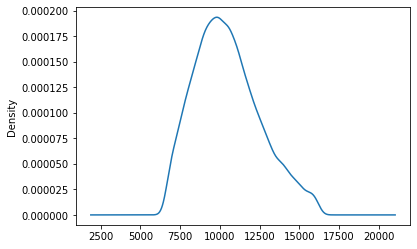

In [107]:
buildings_filter['price_index'].plot.kde()

<AxesSubplot:xlabel='surface', ylabel='price'>

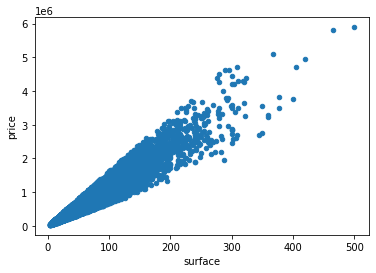

In [108]:
buildings_filter.plot.scatter('surface', 'price')

In [109]:
buildings_filter.describe()

,price,borrow,nb_lots,property_type,surface,longitude,latitude,price_index
count,2.610400e+04,26104.000000,26104.000000,26104.0,26104.000000,26104.000000,26104.000000,26104.000000
mean,5.682853e+05,75113.765400,1.704490,2.0,53.448552,2.336684,48.864478,10466.711504
std,4.570347e+05,4.902487,0.803071,0.0,38.074221,0.037763,0.020194,2064.694178
min,2.700000e+04,75101.000000,1.000000,2.0,3.000000,2.255896,48.819710,6666.650000
25%,2.832360e+05,75110.000000,1.000000,2.0,28.000000,2.305947,48.847357,8935.483871
50%,4.330000e+05,75115.000000,2.000000,2.0,43.000000,2.340614,48.867182,10250.000000
75%,6.886395e+05,75118.000000,2.000000,2.0,67.000000,2.363498,48.882375,11760.140845
max,5.890500e+06,75120.000000,15.000000,2.0,500.000000,2.411386,48.900565,16242.275000


In [110]:
buildings_filter['neighborhood'] = get_neighborhoods(buildings_filter['latitude'], buildings_filter['longitude'], paris_neigh, buildings_filter['borrow'])
buildings_filter

<ipython-input-110-a2d10b5f85ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buildings_filter['neighborhood'] = get_neighborhoods(buildings_filter['latitude'], buildings_filter['longitude'], paris_neigh, buildings_filter['borrow'])


,transaction_type,price,borrow,nb_lots,property_type,surface,longitude,latitude,price_index,neighborhood
0,Vente,1196000.0,75101,2,2.0,112.0,2.325288,48.868416,10678.571429,7510104
1,Vente,1570490.0,75103,2,2.0,104.0,2.363076,48.860305,15100.865385,7510303
5,Vente,230000.0,75103,1,2.0,26.0,2.354961,48.868615,8846.153846,7510301
7,Vente,955750.0,75108,2,2.0,80.0,2.314393,48.880118,11946.875000,7510804
8,Vente,506800.0,75103,1,2.0,45.0,2.362024,48.865675,11262.222222,7510302
...,...,...,...,...,...,...,...,...,...,...
57716,Vente,480000.0,75102,2,2.0,42.0,2.350482,48.865949,11428.571429,7510204
57719,Vente,696500.0,75104,1,2.0,50.0,2.362102,48.854584,13930.000000,7510402
57720,Vente,852400.0,75104,2,2.0,67.0,2.358859,48.854241,12722.388060,7510402
57748,Vente,680000.0,75102,1,2.0,72.0,2.337572,48.867594,9444.444444,7510202


In [159]:
prices = buildings_filter[['neighborhood', 'price_index']].groupby(by='neighborhood', as_index=False).mean()
prices

,neighborhood,price_index
0,7510101,11803.342220
1,7510102,11640.401326
2,7510103,12648.206344
3,7510104,12075.870027
4,7510201,12654.100070
...,...,...
75,7511904,9407.046917
76,7512001,9245.795022
77,7512002,8663.716691
78,7512003,9404.534709


In [160]:
bins = np.linspace(min(prices['price_index']), max(prices['price_index']),6)
names=[0, .25, .5, .75, 1]
prices['price_bin'] = pd.cut(prices['price_index'], bins, labels=names, include_lowest=True)
prices

,neighborhood,price_index,price_bin
0,7510101,11803.342220,0.75
1,7510102,11640.401326,0.75
2,7510103,12648.206344,1.00
3,7510104,12075.870027,0.75
4,7510201,12654.100070,1.00
...,...,...,...
75,7511904,9407.046917,0.00
76,7512001,9245.795022,0.00
77,7512002,8663.716691,0.00
78,7512003,9404.534709,0.00


In [161]:

# display a map with the prices 
paris_map = folium.Map(location=[paris_lat, paris_long], zoom_start=12, min_zoom=12)

folium.Choropleth(
    geo_data=geo_neigh,
    data=prices,
    columns=['neighborhood', 'price_bin'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Paris Neighborhoods'
).add_to(paris_map)
paris_map

## <u>Modeling and evaluation</u>
## Creating data set for model training
We want to build a data set where you will have for each neighborhood: 
- venues, 
- companies  business fields 
- price index

In [116]:
# one hot encoding of venues
paris_onehot_v = pd.get_dummies(nearby_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe at the beginning
paris_onehot_v.insert(0,'neighborhood', nearby_venues['neighborhood'])
print(paris_onehot_v.shape)
paris_onehot_v.head()

(8944, 486)


,neighborhood,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport Service,Alsatian Restaurant,Alternative Healer,American Restaurant,Antique Shop,...,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,7510101.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7510101.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7510101.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7510101.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7510701.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
# one hot encoding of companies
paris_onehot_c = pd.get_dummies(companies[['naf_label']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe at the beginning
paris_onehot_c.insert(0,'neighborhood', companies['neighborhood'])
print(paris_onehot_c.shape)

paris_onehot_c.head()

(786687, 87)


,neighborhood,Action sociale sans hébergement,Activités administratives et autres activités de soutien aux entreprises,Activités auxiliaires de services financiers et d'assurance,"Activités créatives, artistiques et de spectacle",Activités d'architecture et d'ingénierie ; activités de contrôle et analyses techniques,Activités de location et location-bail,Activités de poste et de courrier,"Activités des agences de voyage, voyagistes, services de réservation et activités connexes",Activités des organisations associatives,...,Services de soutien aux industries extractives,Services relatifs aux bâtiments et aménagement paysager,Sylviculture et exploitation forestière,Transports aériens,Transports par eau,Transports terrestres et transport par conduites,"Travail du bois et fabrication d'articles en bois et en liège, à l'exception des meubles ; fabrication d'articles en vannerie et sparterie",Travaux de construction spécialisés,Télécommunications,Édition
9,7510102.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,7510101.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11,7510102.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
12,7510104.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
13,7510102.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [118]:
# merging the datasets
paris_onehot = paris_onehot_v.append(paris_onehot_c)
print(paris_onehot.shape)
paris_onehot.head()

(795631, 572)


,neighborhood,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport Service,Alsatian Restaurant,Alternative Healer,American Restaurant,Antique Shop,...,Services de soutien aux industries extractives,Services relatifs aux bâtiments et aménagement paysager,Sylviculture et exploitation forestière,Transports aériens,Transports par eau,Transports terrestres et transport par conduites,"Travail du bois et fabrication d'articles en bois et en liège, à l'exception des meubles ; fabrication d'articles en vannerie et sparterie",Travaux de construction spécialisés,Télécommunications,Édition
0,7510101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7510101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7510101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7510101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7510701.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
# grouping by neighborhood
paris_grouped = paris_onehot.groupby('neighborhood').mean().reset_index()
paris_grouped.head()

,neighborhood,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport Service,Alsatian Restaurant,Alternative Healer,American Restaurant,Antique Shop,...,Services de soutien aux industries extractives,Services relatifs aux bâtiments et aménagement paysager,Sylviculture et exploitation forestière,Transports aériens,Transports par eau,Transports terrestres et transport par conduites,"Travail du bois et fabrication d'articles en bois et en liège, à l'exception des meubles ; fabrication d'articles en vannerie et sparterie",Travaux de construction spécialisés,Télécommunications,Édition
0,7510101.0,0.008333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.025000,...,0.000000,0.050086,0.001151,0.000000,0.000000,0.005757,0.000000,0.013817,0.001727,0.013241
1,7510102.0,0.016393,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.036047,0.000108,0.000000,0.000108,0.011258,0.000108,0.017536,0.001948,0.012665
2,7510103.0,0.015748,0.0,0.007874,0.0,0.0,0.0,0.0,0.0,0.023622,...,0.000000,0.072525,0.001727,0.001343,0.000576,0.003454,0.000000,0.008442,0.000576,0.015733
3,7510104.0,0.040323,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.057800,0.000266,0.000266,0.000133,0.007175,0.000133,0.015147,0.001196,0.010497
4,7510201.0,0.008264,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000171,0.017448,0.002908,0.001197,0.000000,0.001540,0.000000,0.007527,0.001368,0.011119


In [170]:
# adding prices bins
paris_grouped = paris_grouped.join(prices[['neighborhood', 'price_bin']].set_index('neighborhood'), on='neighborhood')
paris_grouped

,neighborhood,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport Service,Alsatian Restaurant,Alternative Healer,American Restaurant,Antique Shop,...,Services relatifs aux bâtiments et aménagement paysager,Sylviculture et exploitation forestière,Transports aériens,Transports par eau,Transports terrestres et transport par conduites,"Travail du bois et fabrication d'articles en bois et en liège, à l'exception des meubles ; fabrication d'articles en vannerie et sparterie",Travaux de construction spécialisés,Télécommunications,Édition,price_bin
0,7510101.0,0.008333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.025000,...,0.050086,0.001151,0.000000,0.000000,0.005757,0.000000,0.013817,0.001727,0.013241,0.75
1,7510102.0,0.016393,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.036047,0.000108,0.000000,0.000108,0.011258,0.000108,0.017536,0.001948,0.012665,0.75
2,7510103.0,0.015748,0.0,0.007874,0.0,0.000000,0.0,0.000000,0.0,0.023622,...,0.072525,0.001727,0.001343,0.000576,0.003454,0.000000,0.008442,0.000576,0.015733,1.00
3,7510104.0,0.040323,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.057800,0.000266,0.000266,0.000133,0.007175,0.000133,0.015147,0.001196,0.010497,0.75
4,7510201.0,0.008264,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.017448,0.002908,0.001197,0.000000,0.001540,0.000000,0.007527,0.001368,0.011119,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,7511904.0,0.000000,0.0,0.000000,0.0,0.008403,0.0,0.000000,0.0,0.000000,...,0.049280,0.000105,0.000000,0.000000,0.021225,0.000420,0.039823,0.001366,0.010192,0.00
76,7512001.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.043156,0.000748,0.000000,0.000075,0.030366,0.000150,0.109125,0.002319,0.007479,0.00
77,7512002.0,0.000000,0.0,0.009091,0.0,0.000000,0.0,0.009091,0.0,0.000000,...,0.039477,0.000139,0.000000,0.000000,0.037392,0.000278,0.039616,0.001112,0.009591,0.00
78,7512003.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.007874,...,0.048301,0.000725,0.000000,0.000000,0.026566,0.000403,0.093061,0.001369,0.010546,0.00


## Functions for clusturing

In [196]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def get_neighborhoods_venues_sorted(grouped):
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['neighborhood'] = grouped['neighborhood']

    for ind in np.arange(grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted

def clusturing(data, grouped, kclusters):

    grouped_clustering = grouped.drop('neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

    merged = data
    # add clustering labels
    ns = get_neighborhoods_venues_sorted(grouped)
    ns.insert(0, 'cluster_labels', kmeans.labels_)

    # merge grouped with data to add latitude/longitude for each neighborhood
    merged = merged.join(ns.set_index('neighborhood'), on='n_insee')

    merged.dropna(subset=['cluster_labels'], inplace=True)
    return merged

In [304]:
kclusters = 5
col_to_keep = ['n_insee', 'center', 'neigh_name', ]
paris_clus = clusturing(paris_neigh[col_to_keep], paris_grouped, kclusters)
paris_clus

,n_insee,center,neigh_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,7510101,"[48.8606501352, 2.33491032928]",Saint-Germain-l'Auxerrois,3,"Commerce de détail, à l'exception des automobi...",Activités juridiques et comptables,Activités des sièges sociaux ; conseil de gestion,Activités des organisations associatives,Exhibit,Restauration,Monument / Landmark,Services relatifs aux bâtiments et aménagement...,"Activités des services financiers, hors assura...","Activités créatives, artistiques et de spectacle"
41,7510102,"[48.8622891081, 2.34489885831]",Halles,3,Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Activités juridiques et comptables,Restauration,French Restaurant,"Commerce de gros, à l'exception des automobile...",Activités des organisations associatives,"Activités créatives, artistiques et de spectacle",Men's Store,"Activités des services financiers, hors assura..."
14,7510103,"[48.8646599781, 2.33630891897]",Palais-Royal,3,Activités juridiques et comptables,Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Services relatifs aux bâtiments et aménagement...,Office,Activités des organisations associatives,Nightclub,Hotel,"Activités des services financiers, hors assura...","Commerce de gros, à l'exception des automobile..."
49,7510104,"[48.8670185906, 2.3285816649299997]",Place-Vendôme,2,Jewelry Store,Activités des sièges sociaux ; conseil de gestion,Office,Activités juridiques et comptables,"Commerce de détail, à l'exception des automobi...","Commerce de gros, à l'exception des automobile...",Services relatifs aux bâtiments et aménagement...,Women's Store,"Activités des services financiers, hors assura...",Construction de bâtiments
72,7510201,"[48.8693066381, 2.33343180766]",Gaillon,4,Activités de location et location-bail,Office,Hotel,Activités des sièges sociaux ; conseil de gestion,"Activités des services financiers, hors assura...",Activités juridiques et comptables,"Commerce de détail, à l'exception des automobi...",Bar,Japanese Restaurant,Building
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,7511904,"[48.8786390757, 2.38012728183]",Combat,1,"Activités créatives, artistiques et de spectacle",Activités des sièges sociaux ; conseil de gestion,Activités des organisations associatives,"Commerce de détail, à l'exception des automobi...",Office,"Autres activités spécialisées, scientifiques e...",Services relatifs aux bâtiments et aménagement...,Activités pour la santé humaine,Doctor's Office,Bar
32,7512001,"[48.8715312006, 2.38754923985]",Belleville,0,Travaux de construction spécialisés,"Commerce de détail, à l'exception des automobi...",Office,"Activités créatives, artistiques et de spectacle","Commerce de gros, à l'exception des automobile...",Activités des sièges sociaux ; conseil de gestion,French Restaurant,Bar,Activités des organisations associatives,Services relatifs aux bâtiments et aménagement...
36,7512002,"[48.8710347391, 2.40617153015]",Saint-Fargeau,1,"Activités créatives, artistiques et de spectacle",Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Activités des organisations associatives,Activités de poste et de courrier,Bakery,Bank,"Autres activités spécialisées, scientifiques e...",Enseignement,Pizza Place
5,7512003,"[48.863719484, 2.39527282076]",Père-Lachaise,1,Cemetery,"Activités créatives, artistiques et de spectacle",Travaux de construction spécialisés,Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Activités des organisations associatives,Services relatifs aux bâtiments et aménagement...,"Autres activités spécialisées, scientifiques e...",Activités pour la santé humaine,Bank


In [305]:
paris_clus = paris_clus.join(prices.set_index('neighborhood'), on='n_insee')
paris_clus

,n_insee,center,neigh_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,price_index,price_bin
67,7510101,"[48.8606501352, 2.33491032928]",Saint-Germain-l'Auxerrois,3,"Commerce de détail, à l'exception des automobi...",Activités juridiques et comptables,Activités des sièges sociaux ; conseil de gestion,Activités des organisations associatives,Exhibit,Restauration,Monument / Landmark,Services relatifs aux bâtiments et aménagement...,"Activités des services financiers, hors assura...","Activités créatives, artistiques et de spectacle",11803.342220,0.75
41,7510102,"[48.8622891081, 2.34489885831]",Halles,3,Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Activités juridiques et comptables,Restauration,French Restaurant,"Commerce de gros, à l'exception des automobile...",Activités des organisations associatives,"Activités créatives, artistiques et de spectacle",Men's Store,"Activités des services financiers, hors assura...",11640.401326,0.75
14,7510103,"[48.8646599781, 2.33630891897]",Palais-Royal,3,Activités juridiques et comptables,Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Services relatifs aux bâtiments et aménagement...,Office,Activités des organisations associatives,Nightclub,Hotel,"Activités des services financiers, hors assura...","Commerce de gros, à l'exception des automobile...",12648.206344,1.00
49,7510104,"[48.8670185906, 2.3285816649299997]",Place-Vendôme,2,Jewelry Store,Activités des sièges sociaux ; conseil de gestion,Office,Activités juridiques et comptables,"Commerce de détail, à l'exception des automobi...","Commerce de gros, à l'exception des automobile...",Services relatifs aux bâtiments et aménagement...,Women's Store,"Activités des services financiers, hors assura...",Construction de bâtiments,12075.870027,0.75
72,7510201,"[48.8693066381, 2.33343180766]",Gaillon,4,Activités de location et location-bail,Office,Hotel,Activités des sièges sociaux ; conseil de gestion,"Activités des services financiers, hors assura...",Activités juridiques et comptables,"Commerce de détail, à l'exception des automobi...",Bar,Japanese Restaurant,Building,12654.100070,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,7511904,"[48.8786390757, 2.38012728183]",Combat,1,"Activités créatives, artistiques et de spectacle",Activités des sièges sociaux ; conseil de gestion,Activités des organisations associatives,"Commerce de détail, à l'exception des automobi...",Office,"Autres activités spécialisées, scientifiques e...",Services relatifs aux bâtiments et aménagement...,Activités pour la santé humaine,Doctor's Office,Bar,9407.046917,0.00
32,7512001,"[48.8715312006, 2.38754923985]",Belleville,0,Travaux de construction spécialisés,"Commerce de détail, à l'exception des automobi...",Office,"Activités créatives, artistiques et de spectacle","Commerce de gros, à l'exception des automobile...",Activités des sièges sociaux ; conseil de gestion,French Restaurant,Bar,Activités des organisations associatives,Services relatifs aux bâtiments et aménagement...,9245.795022,0.00
36,7512002,"[48.8710347391, 2.40617153015]",Saint-Fargeau,1,"Activités créatives, artistiques et de spectacle",Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Activités des organisations associatives,Activités de poste et de courrier,Bakery,Bank,"Autres activités spécialisées, scientifiques e...",Enseignement,Pizza Place,8663.716691,0.00
5,7512003,"[48.863719484, 2.39527282076]",Père-Lachaise,1,Cemetery,"Activités créatives, artistiques et de spectacle",Travaux de construction spécialisés,Activités des sièges sociaux ; conseil de gestion,"Commerce de détail, à l'exception des automobi...",Activités des o

In [297]:
def viz(paris_clus, cluster_names = None):

    # display a map with the clusters 
    clusters_map = folium.Map(location=[paris_lat, paris_long], zoom_start=12, min_zoom=12)

    folium.Choropleth(
        geo_data=geo_neigh,
        data=paris_clus,
        columns=['n_insee', 'price_bin'],
        key_on='feature.properties.c_quinsee',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        control=False,
        legend_name='Real eastate prices'
    ).add_to(clusters_map)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.ocean(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    #group0 = folium.FeatureGroup(name='<span style=\\"color: red;\\">red circles</span>')
    #group0.add_to(clusters_map)
    groups = {}
    if not cluster_names:
        cluster_names = ['Cluster ' + str(s) for s in set(paris_clus['cluster_labels'])]
    for cn in cluster_names:
        groups[cn] = folium.FeatureGroup(name=cn)
        groups[cn].add_to(clusters_map)
    folium.map.LayerControl('bottomleft', collapsed=False).add_to(clusters_map)

    # add markers to the map
    markers_colors = []
    for center, poi, cluster in zip(paris_clus['center'], paris_clus['neigh_name'], paris_clus['cluster_labels']):
        lat = center[0]
        lon = center[1]
        name = cluster_names[int(cluster)]
        label = folium.Popup(str(poi) + ' <br>\n ' + name, max_width=1000)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster-1)],
            fill=True,
            fill_color=rainbow[int(cluster-1)],
            fill_opacity=0.7).add_to(groups[name])
    return clusters_map

In [306]:
viz(paris_clus)

In [248]:
def common_venues(df, grouped):
    print(df.shape[0], 'Neighborhood in the cluster')
    val = df.drop('n_insee', axis=1).to_numpy().flatten()
    unique_elements, counts_elements = np.unique(val, return_counts=True)
    nb = df['n_insee']
    col = np.concatenate([['neighborhood'], unique_elements])
    freq = grouped.loc[grouped['neighborhood'].isin(nb), grouped.columns.isin(col)]
    freq.set_index('neighborhood', inplace=True)
    freq = freq.transpose()
    # add a total
    freq['total'] = freq.sum(axis=1)
    freq.sort_values(by='total', ascending=False, inplace=True)
    return freq[['total']]

In [300]:
mc = []
for i in range(kclusters):
    print('cluster ', i, ':')
    c = paris_clus.loc[paris_clus['cluster_labels'] == i, paris_clus.columns[[0] + list(range(4, paris_clus.shape[1]-2))]]
    mc.append(common_venues(c, paris_grouped))
    print (mc[i].head(100))
    print("")

cluster  0 :
11 Neighborhood in the cluster
neighborhood                                           total
Office                                              1.274568
Activités des sièges sociaux ; conseil de gestion   1.006040
Activités créatives, artistiques et de spectacle    0.896185
Commerce de détail, à l'exception des automobil...  0.878314
Tech Startup                                        0.762003
Commerce de gros, à l'exception des automobiles...  0.694633
Activités des organisations associatives            0.579910
Services relatifs aux bâtiments et aménagement ...  0.577798
Restauration                                        0.528848
Travaux de construction spécialisés                 0.473604
Autres activités spécialisées, scientifiques et...  0.409544
Coworking Space                                     0.325519
Residential Building (Apartment / Condo)            0.301330
Art Gallery                                         0.292537
Activités des services financiers, hors a

In [308]:
# create names for clusters:
cluster_names = ['Arts and Tech startups', 'Arts, NGO and health', 'Legal, acconting and finance', 'Touristic area', 'Rental']
viz(paris_clus, cluster_names)